# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
seed = 69
set_seed(seed)


1. Define the model class.

In [2]:
dropout_rate = 0.2


class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits


In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, train_correct = 0, 0

    for _batch, (X, y) in enumerate(dataloader, 0):
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += ((pred > 0.5).float().squeeze() == y.float()).sum().item()

    train_loss /= size
    train_correct /= size

    return train_loss, train_correct


In [4]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.squeeze(), y).item()
            test_correct += ((pred > 0.5).float().squeeze() == y.float()).sum().item()

    test_loss /= size
    test_correct /= size

    return test_loss, test_correct


#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [5]:
from common_utils import split_dataset, preprocess_dataset

test_size = 0.3


def preprocess(df):
    X_train, y_train, X_test, y_test = split_dataset(
        df, ["filename", "label"], test_size, seed
    )
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test


df = pd.read_csv("simplified.csv")
df["label"] = df["filename"].str.split("_").str[-2]

df["label"].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [6]:
batch_size = 256


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self._transform(self.X[idx]), self._transform(self.y[idx])

    def _transform(self, data):
        return torch.tensor(data, dtype=torch.float)


def initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    training_data = CustomDataset(X_train_scaled, y_train)
    testing_data = CustomDataset(X_test_scaled, y_test)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)
    return train_dataloader, test_dataloader


train_dataloader, test_dataloader = initialise_loaders(
    X_train_scaled, y_train, X_test_scaled, y_test
)


2. Next, define the model, optimizer and loss function.

In [7]:
learning_rate = 0.001

model = MLP(no_features=77, no_hidden=128, no_labels=1)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
loss_fn = nn.BCELoss()


3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [8]:
from common_utils import EarlyStopper

max_epochs = 100
patience = 3

train_losses, train_corrects = [], []
test_losses, test_corrects = [], []

early_stopper = EarlyStopper(patience)

for epoch in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

    train_losses.append(train_loss), train_corrects.append(train_correct)
    test_losses.append(test_loss), test_corrects.append(test_correct)

    print(
        f"Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}"
    )

    if early_stopper.early_stop(test_loss):
        print("Done!")
        break


Epoch 1: Train_accuracy: 54.75%, Train_loss: 0.002682, Test_accuracy: 56.03%, Test_loss: 0.002816
Epoch 2: Train_accuracy: 58.13%, Train_loss: 0.002632, Test_accuracy: 59.20%, Test_loss: 0.002765
Epoch 3: Train_accuracy: 60.14%, Train_loss: 0.002594, Test_accuracy: 60.36%, Test_loss: 0.002751
Epoch 4: Train_accuracy: 61.77%, Train_loss: 0.002544, Test_accuracy: 61.66%, Test_loss: 0.002695
Epoch 5: Train_accuracy: 63.44%, Train_loss: 0.002502, Test_accuracy: 63.68%, Test_loss: 0.002651
Epoch 6: Train_accuracy: 65.10%, Train_loss: 0.002443, Test_accuracy: 63.16%, Test_loss: 0.002640
Epoch 7: Train_accuracy: 66.80%, Train_loss: 0.002362, Test_accuracy: 63.60%, Test_loss: 0.002672
Epoch 8: Train_accuracy: 67.57%, Train_loss: 0.002332, Test_accuracy: 65.67%, Test_loss: 0.002577
Epoch 9: Train_accuracy: 69.63%, Train_loss: 0.002261, Test_accuracy: 65.70%, Test_loss: 0.002547
Epoch 10: Train_accuracy: 70.40%, Train_loss: 0.002225, Test_accuracy: 67.11%, Test_loss: 0.002529
Epoch 11: Train_acc

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


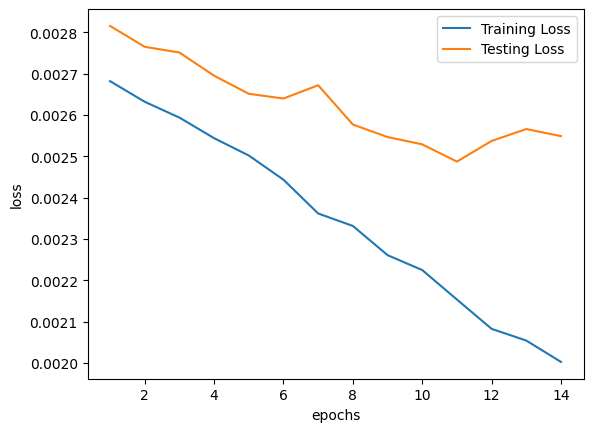

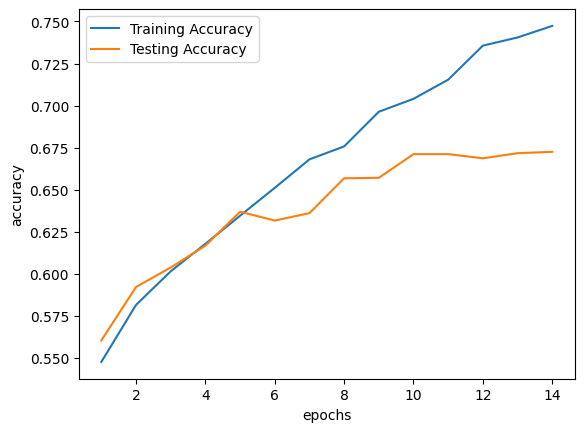

In [9]:
import matplotlib.pyplot as plt

loss_fig = plt.figure(1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

acc_fig = plt.figure(2)
plt.plot(range(1, len(train_corrects) + 1), train_corrects, label="Training Accuracy")
plt.plot(range(1, len(test_corrects) + 1), test_corrects, label="Testing Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


2. Comment on line plots.

In [ ]:
answer = "The model is overfitting"
